In [1]:
# libraries
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import random
import cv2
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import keras
import tensorflow as tf

from keras import models, layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-08-13 09:54:26.081593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 09:54:26.081764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 09:54:26.219024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images_path = '/kaggle/input/sign-language/KSL-dataset/Images'
test_path = '/kaggle/input/sign-language/KSL-dataset/Test.csv'
train_path = '/kaggle/input/sign-language/KSL-dataset/Train.csv'

# **Exploratory analysis of training dataset**
## 1.**Train data**

In [3]:
train_df = pd.read_csv(train_path)
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [4]:
# different classes of images

train_df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [5]:
train_df.shape

(6249, 2)

> Training images constitutes of 6,294 images  with 9 different classes.

**Sample images**

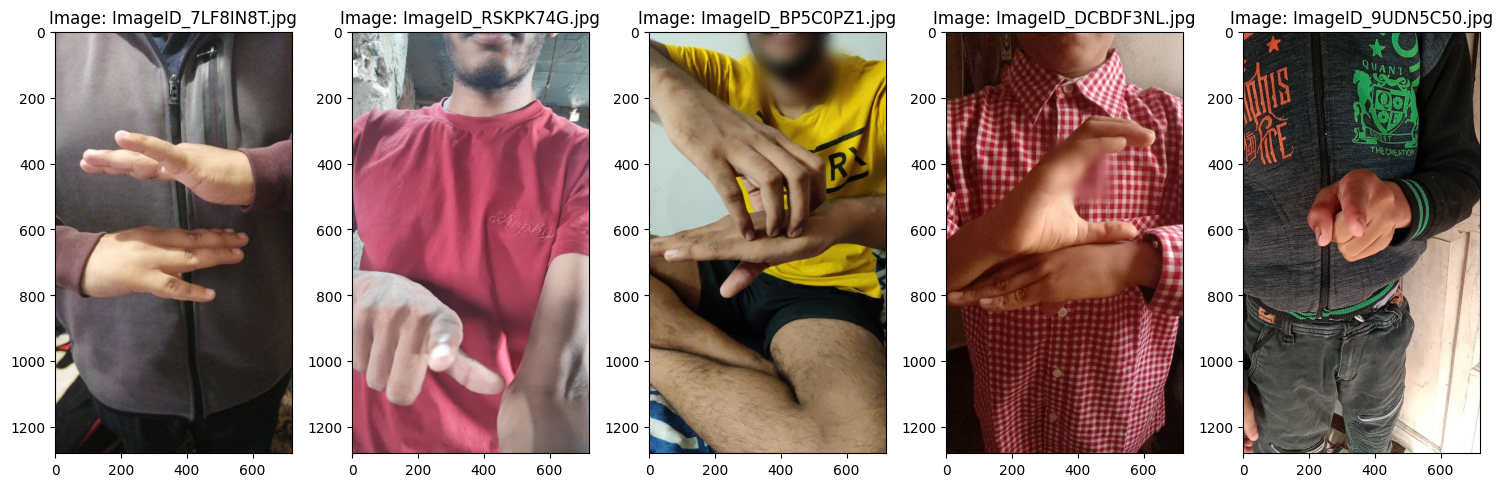

In [6]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
random_images = random.sample(images, 5)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('on')
plt.tight_layout()
plt.show()

From the sample visulization, all the images bearing different sign languages have varying sizes. Some images are larger widths or heights than the others.

**Image mapping to corresponding labels**

In [7]:
class KSL:
    def __init__(self, imgs_path, df, LR = 1e-4, IMG_SIZE = 256, BATCH_SIZE = 32):
        self.imgs_path = imgs_path
        self.df = df
        self.LR = LR
        self.IMG_SIZE = IMG_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        
    def create_mapping(self):
        # Mapping image ids, their paths, and labels together - All images are .jpg format
        self.df['img_path'] = self.df['img_IDS'].apply(lambda x: 
                                                os.path.join(self.imgs_path, f"{x}.jpg"))
        class_mapping = {label: idx for idx, label in enumerate(self.df['Label'].unique())}
        self.df['Encoded_Label'] = self.df['Label'].map(class_mapping)
        return self.df
 

    def crop_center(self, image, crop_size=(600, 600),  target_size=(256, 256)):
        h, w, _ = image.shape
        crop_h, crop_w = crop_size

        start_x = (w - crop_w) // 2
        start_y = (h - crop_h) // 2

        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        
        resized_image = cv2.resize(cropped_image, target_size)    
        
        # Convert to YUV color space
        img_yuv = cv2.cvtColor(resized_image, cv2.COLOR_RGB2YUV)
        # Ensure the Y channel is in the correct format
        img_y_channel = img_yuv[..., 0].astype(np.uint8)  # Convert to uint8 if not already
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[..., 0] = clahe.apply(img_y_channel)
        # Convert back to RGB
        equalized_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return equalized_image
    
    def plot_images_with_labels(self, num_images=5, crop_size=(600, 600),  target_size=(256, 256)):
        df = self.create_mapping()
        plt.figure(figsize=(15, 10))
        sample_df = df.sample(num_images)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            # Load the image
            img_path = row['img_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            resized_img = self.crop_center(img, crop_size=crop_size,target_size = target_size )
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(resized_img)
            plt.title(row["Label"])
            plt.axis('on')
        plt.tight_layout()
        plt.show()
        
    def process_ksl_images(self):
        df = self.create_mapping()
        
        def preprocessing_function(img):
            return self.crop_center(img, crop_size=(600, 600), target_size=(self.IMG_SIZE, self.IMG_SIZE))
        
        datagen=ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.25,
                                   preprocessing_function=preprocessing_function
                                  )
        train_images=datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE,self.IMG_SIZE))
        validation_images=datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="validation",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE,self.IMG_SIZE))
        training_steps=train_images.n//train_images.batch_size
        validation_steps=validation_images.n//validation_images.batch_size
        return train_images, validation_images, training_steps, validation_steps
        
    def ksl_model(self):
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        for layer in resnet_model.layers[:10]:
            layer.trainable = False

        hm = resnet_model.output
        hm = AveragePooling2D(pool_size=(4, 4))(hm)
        hm = Flatten(name='flatten')(hm)
        hm = Dense(9, activation='softmax')(hm)
        model = tf.keras.models.Model(inputs=resnet_model.input, outputs=hm)
        model.compile(optimizer = Adam(learning_rate=self.LR), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [8]:
ksl = KSL(imgs_path=images_path, df=train_df)
df = ksl.create_mapping()

In [9]:
df.head()

,img_IDS,Label,img_path,Encoded_Label
0,ImageID_33HMDMJ3,Temple,/kaggle/input/sign-language/KSL-dataset/Images...,0
1,ImageID_V5POEX4O,Church,/kaggle/input/sign-language/KSL-dataset/Images...,1
2,ImageID_89CCCCW6,Enough/Satisfied,/kaggle/input/sign-language/KSL-dataset/Images...,2
3,ImageID_GNJXOWX5,Me,/kaggle/input/sign-language/KSL-dataset/Images...,3
4,ImageID_7Q9LOP7R,Love,/kaggle/input/sign-language/KSL-dataset/Images...,4


In [10]:
df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [11]:
df.shape

(6249, 4)

In [12]:
df.head()

,img_IDS,Label,img_path,Encoded_Label
0,ImageID_33HMDMJ3,Temple,/kaggle/input/sign-language/KSL-dataset/Images...,0
1,ImageID_V5POEX4O,Church,/kaggle/input/sign-language/KSL-dataset/Images...,1
2,ImageID_89CCCCW6,Enough/Satisfied,/kaggle/input/sign-language/KSL-dataset/Images...,2
3,ImageID_GNJXOWX5,Me,/kaggle/input/sign-language/KSL-dataset/Images...,3
4,ImageID_7Q9LOP7R,Love,/kaggle/input/sign-language/KSL-dataset/Images...,4


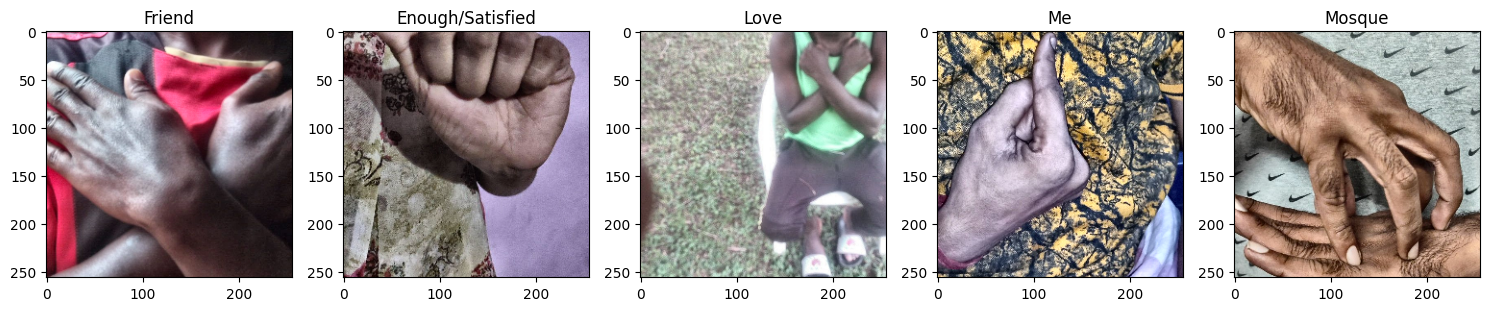

In [13]:
ksl.plot_images_with_labels()

In [14]:
ksl.ksl_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


<Functional name=functional, built=True>

In [15]:
model = ksl.ksl_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,661,449 (90.26 MB)

 Trainable params: 23,594,441 (90.01 MB)

 Non-trainable params: 67,008 (261.75 KB)

In [16]:
train_images, validation_images, training_steps, validation_steps = ksl.process_ksl_images()

Found 4687 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.


In [17]:
print(f"Training steps:{training_steps}")
print(f"Validation steps: {validation_steps}")

Training steps:146
Validation steps: 48


In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(train_images,
                    steps_per_epoch=training_steps,
                    validation_data=validation_images,
                    validation_steps=validation_steps,
                    epochs=30,
                    callbacks =[reduce_lr]
                    )


Epoch 1/30


I0000 00:00:1723542978.927804     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 ━━━━━━━━━━━━━━━━━━━━ 187s 813ms/step - accuracy: 0.4541 - loss: 1.5965 - val_accuracy: 0.1237 - val_loss: 2.5998 - learning_rate: 1.0000e-04
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7500 - loss: 0.7486 - val_accuracy: 0.0385 - val_loss: 2.8764 - learning_rate: 1.0000e-04
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 338ms/step - accuracy: 0.9055 - loss: 0.3060 - val_accuracy: 0.1230 - val_loss: 2.5342 - learning_rate: 1.0000e-04
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.8750 - loss: 0.2497 - val_accuracy: 0.1154 - val_loss: 2.5688 - learning_rate: 1.0000e-04
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 50s 328ms/step - accuracy: 0.9901 - loss: 0.0621 - val_accuracy: 0.1198 - val_loss: 2.5183 - learning_rate: 1.0000e-04
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 1.0000 - loss: 0.0633 - val_accuracy: 0.0769 - val_loss: 2.2905 - learning_rate: 1.0000e-04
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 322ms/step - acc